# Predicting sale price of bulldozers using machine learning

## 1. Problem Definition

> How well can we predict the future auction sale price of a bulldozer given its characteristics and the sale price of historic sales

## 2. Data

> Downloaded from Kaggle Bluebook for Bulldozers competition https://www.kaggle.com/c/bluebook-for-bulldozers/overview

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

> The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices. (from Kaggle)

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

## 4. Features

In [6]:
data_dictionary = pd.read_excel('data/Data Dictionary.xlsx')
data_dictionary

C:\Users\smitt\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Variable,Description,Unnamed: 2
0,SalesID,unique identifier of a particular sale of a ...,NaN
1,MachineID,identifier for a particular machine; machin...,NaN
2,ModelID,identifier for a unique machine model (i.e. ...,NaN
3,datasource,source of the sale record; some sources are...,NaN
4,auctioneerID,"identifier of a particular auctioneer, i.e. ...",NaN
5,YearMade,year of manufacturer of the Machine,NaN
6,MachineHoursCurrentMeter,current usage of the machine in hours at tim...,NaN
7,UsageBand,"value (low, medium, high) calculated compari...",NaN
8,Saledate,time of sale,NaN
9,Saleprice,cost of sale in USD,NaN


In [8]:
# Import training and test
df = pd.read_csv('data/TrainAndValid.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [10]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

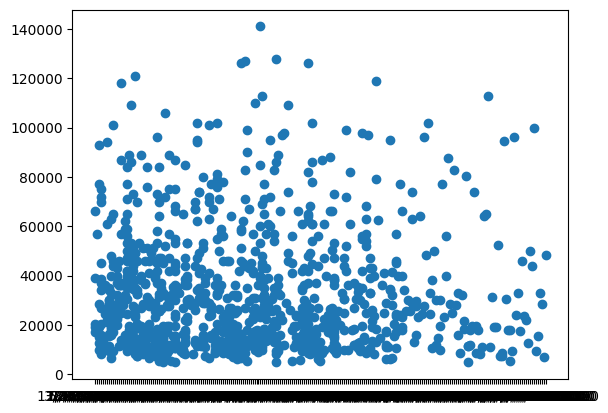

In [12]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

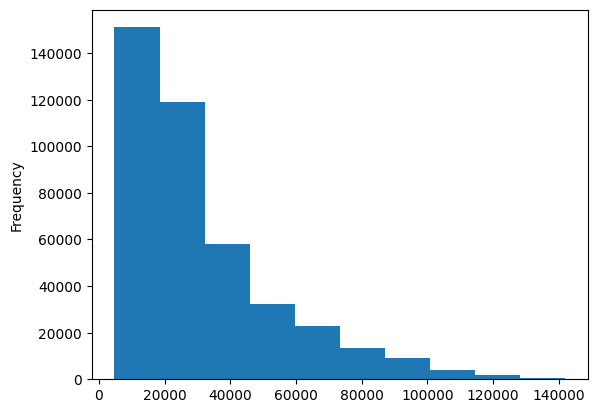

In [13]:
df['SalePrice'].plot.hist();

### Parsing dates

We want to enrich the time & date component as much as possible using `parse_dates`

In [15]:
df = pd.read_csv('data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

In [16]:
df['saledate'].dtype

dtype('<M8[ns]')

In [17]:
df['saledate'].head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

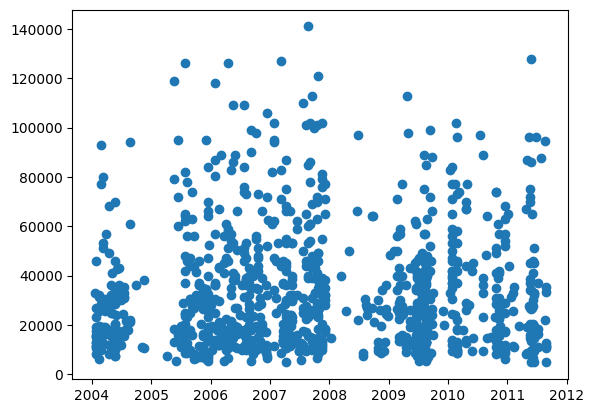

In [18]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [19]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [20]:
# Sort data by saledate
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df['saledate'].head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [21]:
# Make a copy
df_tmp = df.copy()

### Add datetime attributes for saledate

In [22]:
df_tmp['saleYear'] = df_tmp['saledate'].dt.year
df_tmp['saleMonth'] = df_tmp['saledate'].dt.month
df_tmp['saleDay'] = df_tmp['saledate'].dt.day
df_tmp['saleDayOfweek'] = df_tmp['saledate'].dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

In [23]:
df_tmp.drop('saledate', axis=1, inplace=True)

In [24]:
df_tmp['state'].value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

### Converting string to categories

In [28]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [29]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [33]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [34]:
df_tmp['state'].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [35]:
df_tmp['state'].cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [36]:
df_tmp.isnull().sum() / len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data

In [37]:
df_tmp.to_csv('data/train_tmp.csv', index=False)

## Fill Missing Values

In [39]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfweek
saleDayOfYear


In [43]:
# Filling numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_tmp[label + '_is_missing'] = pd.isnull(content)
            # Fill with median
            df_tmp[label] = content.fillna(content.median())
            # Filled auctioneer ID with median values seems suspect but here we are

In [46]:
# Filling categorical values
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # add binary column
        df_tmp[label + '_is_missing'] = pd.isnull(content)
        # Turn categoris into numbers and add 1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [47]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [48]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [50]:
df_tmp.isna().sum().value_counts()

0    103
Name: count, dtype: int64

## 5. Modeling

In [51]:
%%time

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

CPU times: total: 12min 44s
Wall time: 51.8 s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [52]:
# Score the model
model.score(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

0.9875468079970562

### Splitting into train and validate

In [54]:
df_val = df_tmp[df_tmp['saleYear'] == 2012]
df_train = df_tmp[df_tmp['saleYear'] != 2012]

df_val.shape, df_train.shape

((11573, 103), (401125, 103))

In [55]:
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Build an evaluation function

In [62]:
def rmsle(y_test, y_preds):
    """
    Calculate root mean squared log error between predictions and labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Valid MAE': mean_absolute_error(y_valid, val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              'Valid RMSLE': rmsle(y_valid, val_preds),
              'Training r2': r2_score(y_train, train_preds),
              'Valid r2': r2_score(y_valid, val_preds)}
    return scores

### Testing the model on a subset (to tune hyperparameters)

In [59]:
# Change max samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [60]:
%%time
model.fit(X_train, y_train)

CPU times: total: 26.6 s
Wall time: 2.09 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [63]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training r2': 0.8606658995199189,
 'Valid r2': 0.8320374995090507}

### Hyperparameter tuning

In [70]:
%%time
rf_grid = {'n_estimators': np.arange(10, 100, 10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, 'sqrt', 'log2'],
           'max_samples': [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                                                    param_distributions=rf_grid,
                                                    n_iter=100,
                                                    verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 10min 47s
Wall time: 5min 58s


RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'log2'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [71]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 14,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [72]:
show_scores(rs_model)

{'Training MAE': 6014.995758135988,
 'Valid MAE': 7358.2304439685795,
 'Training RMSLE': 0.2739455275270367,
 'Valid RMSLE': 0.29871336285950023,
 'Training r2': 0.8386396677154762,
 'Valid r2': 0.8230558957662024}

In [74]:
%%time
new_model = RandomForestRegressor(n_jobs=-1,
                                  random_state=42,
                                  n_estimators=90,
                                  min_samples_split=14,
                                  min_samples_leaf=3,
                                  max_features=0.5,
                                  max_depth=None)

new_model.fit(X_train, y_train)

CPU times: total: 4min 35s
Wall time: 18.5 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3,
                      min_samples_split=14, n_estimators=90, n_jobs=-1,
                      random_state=42)

In [75]:
show_scores(new_model)

{'Training MAE': 3127.535084689853,
 'Valid MAE': 5911.192187602347,
 'Training RMSLE': 0.15403539091594634,
 'Valid RMSLE': 0.24263346747551662,
 'Training r2': 0.9523281103450383,
 'Valid r2': 0.8820525062258318}

In [76]:
%%time
# parameters from training
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    random_state=42,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

CPU times: total: 2min 6s
Wall time: 8.44 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [77]:
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.2452416398953833,
 'Training r2': 0.9588145522577225,
 'Valid r2': 0.8818019502450094}

## Make predictions on test data

In [80]:
df_test = pd.read_csv('data/Test.csv', low_memory=False, parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing test

In [82]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [81]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df
    """
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['saleDay'] = df['saledate'].dt.day
    df['saleDayOfweek'] = df['saledate'].dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear

    df.drop(['saledate'], axis=1, inplace=True)

    # Filling numeric values
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label + '_is_missing'] = pd.isnull(content)
                # Fill with median
                df[label] = content.fillna(content.median())

    # Filling categorical values
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            # add binary column
            df[label + '_is_missing'] = pd.isnull(content)
            # Turn categoris into numbers and add 1
            df[label] = pd.Categorical(content).codes + 1

    return df

In [83]:
df_test = preprocess_data(df_test)
df_test.shape

(12457, 101)

In [84]:
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [88]:
df_test['auctioneerID_is_missing'] = False
df_test = df_test.reindex(columns=list(X_train.columns))
df_test.shape

(12457, 102)

In [89]:
test_preds = new_model.predict(df_test)
test_preds

array([18034.71035502, 16417.5665384 , 48560.3370767 , ...,
       12346.68359095, 15515.82818498, 26042.1780594 ])

In [90]:
# Format predictinos into format Kaggle is after
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds
df_preds.head()

,SalesID,SalesPrice
0,1227829,18034.710355
1,1227844,16417.566538
2,1227847,48560.337077
3,1227848,66475.485926
4,1227863,55296.628825


In [91]:
# Export prediction data
df_preds.to_csv('data/test_predictions.csv', index=False)

### Feature Importance

In [92]:
new_model.feature_importances_

array([3.50281179e-02, 1.72727784e-02, 4.16286038e-02, 1.85962625e-03,
       3.02539025e-03, 2.10608425e-01, 2.91922464e-03, 9.32298186e-04,
       4.66702180e-02, 4.48345111e-02, 5.99773275e-02, 4.66945060e-03,
       1.42710628e-02, 1.57630393e-01, 4.41007930e-02, 5.35604570e-03,
       2.21219684e-03, 2.21370742e-03, 3.93878785e-03, 5.94176160e-02,
       4.83813691e-04, 5.84268661e-05, 9.75329032e-04, 2.91391040e-04,
       1.22256225e-03, 4.78924607e-05, 2.03890447e-03, 7.12970060e-03,
       5.66860584e-04, 1.92908070e-03, 3.88765068e-03, 3.28007872e-03,
       3.78117621e-03, 2.12319290e-03, 4.04497976e-04, 6.59905375e-03,
       7.81369070e-04, 1.18061077e-02, 8.97338954e-04, 2.88102330e-03,
       8.43616594e-04, 9.26971915e-04, 2.28223612e-03, 5.91624969e-04,
       4.02416864e-04, 3.04243774e-04, 2.78601228e-04, 1.69448279e-03,
       9.28142140e-04, 1.71113020e-04, 5.33512336e-04, 7.28859678e-02,
       3.74154466e-03, 5.09772809e-03, 2.60770013e-03, 9.18235312e-03,
      

In [97]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))

    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis()

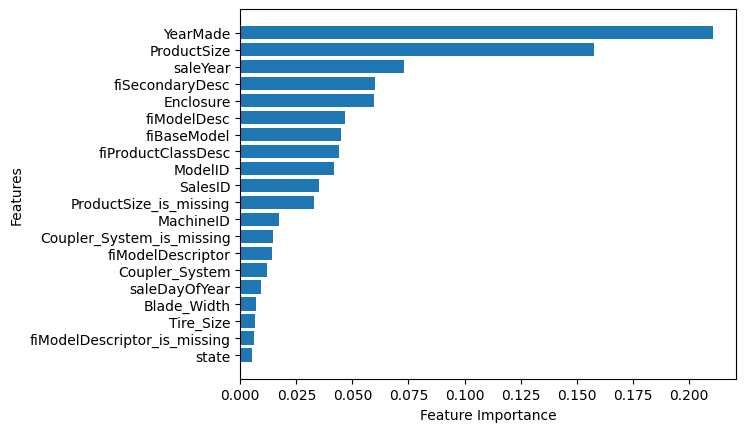

In [98]:
plot_features(X_train.columns, new_model.feature_importances_)